The following code was written by Andrew Bailey and Trevor Pesout. We both contributed equally. 

In [1]:
#!/usr/bin/env python
"""Module Docstrings"""
########################################################################
# File: template.py
#  executable: template.py
#
# Author: Andrew Bailey/ Trevor Pesout
# History: Created 10/18/17
########################################################################

from __future__ import print_function
import sys
from timeit import default_timer as timer
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import numpy as np
import math
from scipy.special import expit


def sigmoid(x, alpha=1, beta=0):
    """Sigmoid function"""

    # this can overflow a double, so we use different implementations
    # return math.exp(alpha*(x+beta)) / (1 + math.exp(alpha*(x+beta)))
    if x < 0:
        return 1 - 1 / (1 + math.exp(alpha*(x+beta)))
    else:
        return 1 / (1 + math.exp(-alpha*(x+beta)))



def integral_of_sigmoid(x):
    """Returns the value from the integral of the sigmoid function"""
    return np.log((1+np.exp(x)))


def iterative_reweighted_least_squares(inputs, labels, weights):
    """Newton-Raphson iterative reweighted least squares"""


def logistic_hessian(inputs, weights):
    """Calculate hessian matrix for logistic regression"""
    y_hat = logistic_evaluation(inputs, weights)
    b = np.array([1-y for y in y_hat])
    # p(1-p)

    prob = [y_hat*b]
    n = len(prob[0])
    assert n == len(y_hat)
    d = np.repeat(prob, [n,], axis=0)
    I = np.identity(n)
    R = np.multiply(I, prob)
    # hessian = np.matmul(np.matmul(inputs.T, R), inputs)
    return R

def read_spam_data(csv_f):
    """Read in csv of ham spam data and return two lists of data"""
    label = []
    message = []
    with open(csv_f) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            message.append(row['sms'])
            label.append(row['label'])
            # print(row['label'], row['sms'])
    return message, label


#TODO tpesout: make this persistent, so we can use it with the test data.
# we want to make this use the same features with different data (so we can test)
def create_train_data(corpus, stop_words, bigram=False, lowercase=True):
    """Extract features from corpus and perform the tf-idf term weighting as well as removing stopwords"""
    # option to have 'this word' as a feature along with 'this' and 'word'
    if bigram:
        vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b',
                                     min_df=1, decode_error='ignore', stop_words=stop_words,
                                     lowercase=lowercase)
    else:
        vectorizer = CountVectorizer(decode_error='ignore', stop_words=stop_words, lowercase=lowercase)

    # create feature vector
    X = vectorizer.fit_transform(corpus)
    transformer = TfidfTransformer(smooth_idf=False, norm='l2')
    # normalize and perform tf-idf
    tfidf = transformer.fit_transform(X)
    return tfidf.toarray()


def create_spam_ham_labels(labels_text, spam=1, ham=0):
    """Convert spam and ham into either 0 or 1 """
    integer_labels = []
    for label in labels_text:
        if label == "spam":
            integer_labels.append(spam)
        else:
            assert label == "ham"
            integer_labels.append(ham)
    return integer_labels


def square_loss(features, labels, weights):
    """Calculates total loss of lists of features and labels given weights"""
    total_loss = 0
    for index, feature in enumerate(features):
        a = sigmoid(np.matmul(weights, feature.T))
        total_loss += ((a-labels[index])**2) / 2.0
    return total_loss


def logistic_loss(features, labels, weights):
    """Calculates total loss of lists of features and labels given weights"""
    total_loss = 0
    for index, feature in enumerate(features):
        y = labels[index]
        a = np.matmul(weights, feature.T)
        y_hat = sigmoid(a)
        if y_hat == 0:
            print("ERROR its 0")
        # need to double check this equation
        total_loss += y*np.log(y) + (1-y)*np.log(1-y_hat)
    return total_loss


def logistic_evaluation(inputs, weights):
    """Returns predicted outputs from the inputs and weights"""
    prediction = []
    for index, feature in enumerate(inputs):
        a = np.matmul(weights, feature.T)
        y_hat = sigmoid(a)
        prediction.append(y_hat)
    return np.array(prediction)


def logistic_regression(inputs, labels, weights, l, alpha, eta_0, step):
    """Implement regularized logistic regression with moving learning weight"""
    eta = eta_0*(step**alpha)
    y_hat = logistic_evaluation(inputs, weights)
    new_weights = weights*(1-(eta*l)) - (eta*np.matmul(np.array(y_hat-labels), inputs))
    return new_weights


In [2]:
########################################################
# prepare and load the training data.  this involves
# reading in the data and finding the best features
########################################################

# if cant find stopwords you can download using this:
# import nltk
# nltk.download('stopwords')

# init
stop_words = stopwords.words('english')
train_data = 'train.csv'
# test_data = 'test.csv'

# interpret data
messages, text_labels = read_spam_data(train_data)
all_train_data = create_train_data(messages, stop_words)
int_labels = create_spam_ham_labels(text_labels, spam=1, ham=0)

# get sizes
n_messages = len(messages)
n_features = all_train_data.shape[1]
# make sure everything is still aligned
print(all_train_data.shape)
assert all_train_data.shape[0] == len(messages)
assert all_train_data.shape[0] == len(int_labels)
assert all_train_data.shape[0] == len(text_labels)

(3000, 6117)


In [3]:
########################################################
# this is the definition of the hyper parameters for
# the regression
########################################################

# lambda
lambda_base = 2 #8 #np.e
lambda_exp_min = -1 #-5
lambda_exp_max = 3 #1
list_of_lambdas = [lambda_base**i for i in range(lambda_exp_min,lambda_exp_max+1)] 
print("LAMBDAS:\n\tbase: {}   log_min: {}   log_max: {}\n\t{}".format( 
      lambda_base, lambda_exp_min, lambda_exp_max, list_of_lambdas))

# sigmoid params
eta_0 = 0.1
alpha = 0.9

LAMBDAS:
	base: 2   log_min: -1   log_max: 3
	[0.5, 1, 2, 4, 8]


In [4]:
########################################################
# divide the data for 10-fold cross validation
########################################################

# identifiers
TRAIN_DATA = "t_data"
TRAIN_LABELS = "t_labels"
VALIDATE_DATA = "v_data"
VALIDATE_LABELS = "v_labels"

# prep
number_of_buckets = 10
size_of_bucket = int(n_messages / number_of_buckets)
all_train_buckets = dict()

# divide into buckets
idx = 0
for b in range(number_of_buckets):
    data = all_train_data[idx:idx+size_of_bucket]
    labels = int_labels[idx:idx+size_of_bucket]
    all_train_buckets[b] = [data, labels]
    idx += size_of_bucket
    
    
# how to create train and validation data sets
def get_train_data_set(idx):
    t_data, t_labels = list(), list()
    v_data, v_labels = None, None
    for k in all_train_buckets.keys():
        v = all_train_buckets[k]
        if k == idx:
            v_data = v[0]
            v_labels = v[1]
        else:
            t_data.append(v[0])
            t_labels.append(v[1])
    return {
        TRAIN_DATA: np.vstack(t_data), 
        TRAIN_LABELS: np.hstack(t_labels),  
        VALIDATE_DATA: v_data, 
        VALIDATE_LABELS: v_labels
    }

# get data
all_training_datasets = [get_train_data_set(x) for x in list(range(number_of_buckets))]

# validation
assert len(all_training_datasets) == number_of_buckets
for ds in all_training_datasets:
    assert ds[TRAIN_DATA].shape[1] == n_features
    assert ds[TRAIN_DATA].shape[0] == len(ds[TRAIN_LABELS])
    assert ds[VALIDATE_DATA].shape[1] == n_features
    assert ds[VALIDATE_DATA].shape[0] == len(ds[VALIDATE_LABELS])

In [5]:
########################################################
# definition of our regression function
########################################################


def run_regression(lamda, train, train_labels, validate, validate_labels, 
                   eta_0=0.1, alpha=0.9, iterations=321, verbose=False):
    # init
    report_frequency = int(iterations / 16.0)
    t = None
    
    #run regression
    try:
        weights = np.random.normal(0, 0.2, n_features)
        min_validate_loss = sys.maxsize
        min_train_loss = sys.maxsize
        for t in range(iterations):
            weights = logistic_regression(train, train_labels, weights, lamda, alpha, eta_0, t)
            train_loss = square_loss(train, train_labels, weights=weights)
            val_loss = square_loss(validate, validate_labels, weights=weights)
            if verbose and t % report_frequency == 0:
                print("{}:\t#{}\ttrain {}  \t\tvalidate {}".format(l, t, train_loss, val_loss))
            if val_loss < min_validate_loss: min_validate_loss = val_loss
            if train_loss < min_train_loss: min_train_loss = train_loss
    except Exception as e:
        print("\nlambda {} #{}: {}".format(l, t, e), sys.stderr)
        import traceback
        traceback.print_exc()
        return False
    
    # return best
    return min_validate_loss, min_train_loss

In [6]:
########################################################
# run on each of our k-folded datasets
########################################################

# prep
lambda_to_validate_errors = dict()
lambda_to_training_errors = dict()

print(list_of_lambdas)
# calculate for our lambdas
for l in list_of_lambdas:
    start = timer()
    print("\nLAMBDA: {}\n\t".format(l),end='')
    v_errors = list()
    t_errors = list()
    lambda_to_validate_errors[l] = v_errors
    lambda_to_training_errors[l] = t_errors
    for dataset in all_training_datasets:
        v_error, t_error = run_regression(l, dataset[TRAIN_DATA], dataset[TRAIN_LABELS], 
                       dataset[VALIDATE_DATA], dataset[VALIDATE_LABELS])
        v_errors.append(v_error)
        t_errors.append(t_error)
        print('.', end='')
    print(" ({}s)".format(int(timer() - start)))
    print("\tv errors:    {}".format(v_errors))
    print("\tv error avg: {}".format(np.mean(v_errors)))
    print("\tv error std: {}".format(np.std(v_errors)))

[0.5, 1, 2, 4, 8]

LAMBDA: 0.5
	.......... (189s)
	v errors:    [8.722265972335437, 8.851553887473258, 8.161541421397157, 7.8909732646046455, 8.2513509167522, 8.528565748789068, 7.829298577909078, 7.833769793891729, 7.784868023068944, 6.757337983368127]
	v error avg: 8.061152558958964
	v error std: 0.5689656764164073

LAMBDA: 1
	.......... (205s)
	v errors:    [11.34994706193415, 11.209667760090866, 10.529339206739653, 10.173748238342034, 10.66077608658416, 10.834337085713807, 10.158075353690114, 10.14953536899959, 10.221142869046135, 9.130514611547145]
	v error avg: 10.441708364268766
	v error std: 0.6024931433456062

LAMBDA: 2
	

/Users/andrewbailey/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: overflow encountered in multiply


.......... (228s)
	v errors:    [14.893598505402327, 14.549990924965686, 13.623481794244631, 13.439084507720395, 14.114380954119417, 14.093482607648834, 13.389368375869012, 13.47353815184741, 13.707439290008221, 12.481803259508302]
	v error avg: 13.776616837133423
	v error std: 0.6419321031885954

LAMBDA: 4
	.......... (178s)
	v errors:    [18.894784365058904, 18.27902204610276, 17.8712129397925, 17.46786106934318, 17.941391448334166, 18.005974929368932, 16.224220106448893, 17.20025567738062, 17.5810437066695, 16.266852424886654]
	v error avg: 17.57326187133861
	v error std: 0.7958000234281607

LAMBDA: 8
	.......... (173s)
	v errors:    [20.548131675990238, 19.81448021556645, 18.0561372342424, 17.764334775620107, 19.515614257448004, 19.06745448478471, 16.89772426538649, 18.987700972501973, 19.91704444830481, 16.0]
	v error avg: 18.656862232984516
	v error std: 1.3722788755987347


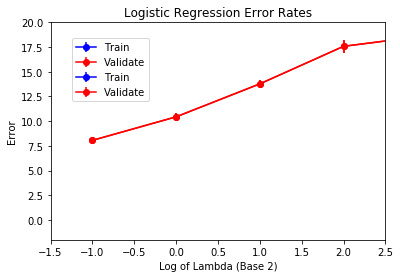

safds
safds
safds


In [8]:
########################################################
# analyze and print plots of the data
########################################################
# %matplotlib inline
import matplotlib.pyplot as plt

def get_plot_data(items):
    items.sort(key=lambda x: x[0])
    x, y, var, log_lambda = list(), list(), list(), lambda_exp_min
    for k, v in items:
        x.append(log_lambda)
        y.append(np.mean(v))
        var.append(np.std(v)**2)
        assert lambda_base**log_lambda == k
        log_lambda += 1
    return x, y, var

validate_x, validate_y, validate_v = get_plot_data(list(lambda_to_validate_errors.items()))
train_x, train_y, train_v = get_plot_data(list(lambda_to_training_errors.items()))

plt.errorbar(train_x, train_y, train_v, None, 'bo-', label="Train")
plt.errorbar(validate_x, validate_y, validate_v, None, 'ro-', label="Validate")
plt.axis([lambda_exp_min-.5, lambda_exp_max-.5, -2, 20])
plt.legend(bbox_to_anchor=(.31,.95))
plt.title("Logistic Regression Error Rates")
plt.xlabel("Log of Lambda (Base {})".format(lambda_base))
plt.ylabel("Error")
plt.show()


## Ham vs Spam: Logistic Regression

##### Andrew Bailey and Trevor Pesout

The task at hand is to classify email headers as either 'spam' or 'ham'. The assumtion is that there are some key words that are in the spam email headers that give them away as spam and by using logistic regression we should be able to classify the difference betwen spam and ham based on the header. 

 ##### _examples:_ 
 
spam - T-Mobile customer you may now claim your FREE CAMERA PHONE upgrade & a pay & go sim card for your loyalty. Call on 0845 021 3680.Offer ends 28thFeb.T&C's apply  


ham  -  Thanks for this hope you had a good day today   

### Natural Language Processing 


We first needed to convert the phrases from the headers of theses emails into a format which is readable by the logistic regression algorithm. 

Some words do not add information such as 'the' and should be removed. Therefore we used the very convenient CountVectorizer class to remove stopwords from all sentences. CountVectorizer also creates an index for each word and vectorizes each input sentence into a count vector. The count vector represents every word in the sentence but it is now in a fixed length vector. In order to normalize the count vector we used TfidfTransformer to weight words by the frequency of their appearance within the entire document. 


$tf(t,d) = $ number of times a term t occurs in document d.  
$n_d$ is the number of documents and $df(d,t)$ is how many documents have term t.
$idf(t,d) = log \frac{n_d}{df(d,t)}+1$ number of times a term t occurs in document d.  
$tfidf(t,d) = tf(t,d)*idf(t,d)$

These counts $tfidf(t,d)$ are then normalized by the Euclidean norm.

Now that we have encoded the sentence information into a vector, we convert the ham and spam labels to 0 and 1 respectively in order to classify each sentence using the logistic regression algorithm.


### Logistic Regression

Now that the inputs have been vectorized, the logistic regression algorithm can be used to determine an optimized weight vector. 

Each sentence is represented by $X = [x_1, x_2, ... x_m]$  
The label of spam or ham is represented by $y \in (0,1)$  
The weight vector is $\mathbf{w} =  [w_1, w_2, ... w_m]$  

The output before the sigmoid function is defined as $a_i = w_0x_0 + w_1x_1 + ... + w_mx_m = \sum_{j=0}^{m} w_j x_j= \mathbf{w}^TX_i$  

Sigmoid function is $\phi(a) = \frac{1}{1 + e^{-a}}$  
Final output is $\phi(a_i) = t_i$

Likelihood  
$L(\mathbf{w}) = P(\mathbf{y} \mid \mathbf{X};\mathbf{w})= \prod_{i=1}^{n} P\big(y^{(i)} \mid X^{(i)}; \mathbf{w}\big)= \prod^{n}_{i=1}\bigg(\phi\big(a^{(i)}\big)\bigg)^{y^{(i)}} \bigg(1-\phi\big(a^{(i)}\big)\bigg)^{1-y^{(i)}}$

Regularization Terms:  
$L2: \frac{\lambda}{2}\lVert \mathbf{w} \lVert_2 = \frac{\lambda}{2} \sum_{j=1}^{m} w_j^2$  
$L1: \lambda\lVert \mathbf{w} \lVert_1 = \lambda \sum_{j=1}^{m} |w_j|$



Objective/Cost Function (Negative Log Likelihood + Regularization)  
$E(w_j) = \sum_{i=1}^{m} \Big[ - y^{(i)} log \bigg( \phi\big(a^{(i)}\big) \bigg) - \big(1 - y^{(i)}\big) log\bigg(1-\phi\big(a^{(i)}\big)\bigg)\Big] - \frac{\lambda}{2} \sum_{j=1}^{m} w_j^2$

Minimize Negative Log Likelihood  
$\begin{align}
\nabla E(w_j) = \frac{\partial}{\partial w_j} l(w_j) &= \sum_{j=1}^{m} \bigg[\bigg(y \frac{1}{\phi(a)} - (1-y) \frac{1}{1-\phi{(a)}} \bigg) \frac{\partial}{\partial w_j}\phi(a) - \frac{\lambda}{2} \frac{\partial}{\partial w_j} w_j^2\bigg] \\ 
&=- \sum_{j=1}^{m} \big(y - \phi(z)\big)x_j - \lambda w_j
\end{align}$


We now have the gradient for the weights and use a decreasing function for the step size $\eta$ in order to decrease the size of the step with each iteration t.

$\begin{align}
\eta &= \eta_0 * t^{-\alpha} \\
\Delta{w_j} & = - \eta \sum_{i=1}^{n}\big(y^{(i)} - \phi\big(z^{(i)}\big) x^{(i)} \big) - \eta \lambda w_j
\end{align}$

We can then turn these gradients into vector representation.
$\begin{align}
\nabla E(\mathbf{w}) = \frac{\partial}{\partial \mathbf{w}} l(\mathbf{w}) &=  - \eta\big(\mathbf{y} - \mathbf{\phi(z)}\big)\mathbf{X}\big) -\mathbf{w}\eta \lambda 
\end{align}$

In order to utilize a bias term the input vector for each sample was prepended with a 1 and the weight vector was not regularized on that term. In order to accomplish this we allowed for a bias regularization option which set the regulzarizers to 0 for that term.  


### Iterative Least Squares Regression

The update for the iterative reweighted least squares is defined as $\mathbf{w}^{(new)} = \mathbf{w}^{(old)} - \mathbf{H}^{-1}\nabla E(\mathbf{w})$

$\begin{align}
\nabla E(\mathbf{w}) = \frac{\partial}{\partial \mathbf{w}} l(\mathbf{w}) &=  - \big(\mathbf{y} - \mathbf{\phi(z)}\big)\mathbf{X}\big) -\mathbf{w}\lambda 
\end{align}$

R is an N X N diagonal matrix with elements $R_{nn} = y_n(1-y_n)$.

$\begin{align}
H &= \nabla \nabla E(\mathbf{w}) = \mathbf{X}^T \mathbf{R} \mathbf{X}
\end{align}$

Therefore the update can be defined as:

$\begin{align}
\mathbf{w}^{(new)} = \mathbf{w}^{(old)} - (\mathbf{X}^T \mathbf{R} \mathbf{X})^{-1} (- \big(\mathbf{y} - \mathbf{\phi(z)}\big)\mathbf{X}\big) -\mathbf{w} \lambda ))
\end{align}
$

### Results



### Analysis

The iterative least squares regression algorithm usually requires significantly fewer iterations than the standard logistic regression algorithm. However, the computing the Hessian is very expensive and with a naieve python implementation takes much longer to reach the minimum. Also, computing the Hessian requires a batch of data, so there is no natural online method using iterative least squares regression. 


